
# Inventory Value Prediction Notebook
 
**Objective:** Build an end-to-end machine learning pipeline to predict inventory value based on historical manufacturing and sales data. This notebook is structured for non-technical stakeholders, explaining each step of the Data Science and Machine Learning methodology.

## 1. Problem Definition
 
- **Business Context:** A coffee manufacturing plant needs to forecast daily inventory value to optimize purchasing and storage costs.
- **Goal:** Predict the inventory value at the end of each day using past production volumes, sales orders, and other operational metrics.
- **Stakeholders:** Production Engineers, Supply Chain Managers, Finance Team.
- **Key Questions:**
- How much inventory value will we hold tomorrow?
- What factors most influence inventory valuation?
- Can we reduce holding costs and stockouts?

## 2. Methodology Overview
 
We will follow a structured Data Science methodology:
1. Data Collection & Generation
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing & Feature Engineering
4. Model Selection & Training
5. Model Evaluation
6. Deployment Plan & Next Steps

## 3. Import Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

## 4. Synthetic Data Generation
 
Since real data is not yet available, we generate a realistic synthetic dataset representing daily records over two years.

In [8]:
# Set seed for reproducibility
np.random.seed(1997)

# create a date range for two years
dates = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')
n = len(dates)

# Simulate production volume (kg), sales orders (kg), unit cost (SAR), holding cost rate
production = np.random.normal(loc=500, scale=50, size=n).clip(min=300)
sales = (production * np.random.uniform(0.7, 1.0, size=n)).round()
unit_cost = np.random.uniform(2.5, 3.5, size=n)
holding_cost_rate = 0.01  # 1% of inventory value per day

# Calculate inventory value based on cumulative production minus cumulative sales
cumulative_prod = np.cumsum(production)
cumulative_sales = np.cumsum(sales)
ending_inventory = (cumulative_prod - cumulative_sales).clip(min=0)
inventory_value = ending_inventory * unit_cost


# Build DataFrame
df = pd.DataFrame({
    'date': dates,
    'production_kg': production,
    'sales_kg': sales,
    'unit_cost_usd': unit_cost,
    'ending_inventory_kg': ending_inventory,
    'inventory_value_usd': inventory_value
})

# Save the synthetic dataset
df.to_excel(r'D:\1-My_GitHub_Repos\Production-Engineering\data\data1.xlsx', index=False)

# Preview
df.head()

,date,production_kg,sales_kg,unit_cost_usd,ending_inventory_kg,inventory_value_usd
0,2023-01-01,522.231999,453.0,3.488281,69.231999,241.500679
1,2023-01-02,501.231193,389.0,3.270406,181.463192,593.458338
2,2023-01-03,499.189204,425.0,2.505930,255.652396,640.647026
3,2023-01-04,511.446746,382.0,3.142859,385.099142,1210.312272
4,2023-01-05,561.330533,464.0,3.093215,482.429675,1492.258827


## 5. Exploratory Data Analysis (EDA)
- Understand distributions
- Check correlations
- Visualize trends

In [9]:
# Summary statistics
print(df.describe())

                      date  production_kg    sales_kg  unit_cost_usd  \
count                  731     731.000000  731.000000     731.000000   
mean   2024-01-01 00:00:00     499.595957  426.793434       3.002820   
min    2023-01-01 00:00:00     358.366152  267.000000       2.500785   
25%    2023-07-02 12:00:00     466.281633  382.000000       2.771561   
50%    2024-01-01 00:00:00     499.407946  422.000000       2.993895   
75%    2024-07-01 12:00:00     530.602669  470.000000       3.258291   
max    2024-12-31 00:00:00     649.800234  620.000000       3.499845   
std                    NaN      50.026710   62.326118       0.290706   

       ending_inventory_kg  inventory_value_usd  
count           731.000000           731.000000  
mean          26569.050334         79674.621718  
min              69.231999           241.500679  
25%           12538.841987         37933.739979  
50%           26476.018172         77667.042064  
75%           40243.840524        119557.416593  
m

In [10]:
# Correlation matrix
corr = df.corr()
print(corr['inventory_value_usd'].sort_values(ascending=False))

inventory_value_usd    1.000000
ending_inventory_kg    0.982330
date                   0.982183
unit_cost_usd          0.135945
production_kg         -0.022914
sales_kg              -0.029763
Name: inventory_value_usd, dtype: float64


## 6. Data Preprocessing & Feature Engineering
 
- Extract date-based features
- Scale numeric variables
- Prepare pipeline


In [11]:
# Date features

df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# Define features and target
features = ['production_kg', 'sales_kg', 'unit_cost_usd', 'ending_inventory_kg', 'day_of_week', 'month']
target = 'inventory_value_usd'
X = df[features]
y = df[target]

# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
numeric_features = ['production_kg', 'sales_kg', 'unit_cost_usd', 'ending_inventory_kg']
categorical_features = ['day_of_week', 'month']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## 7. Model Selection & Pipeline
- We choose a Random Forest Regressor for its balance of performance and interpretability.

In [12]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

## 8. Hyperparameter Tuning


In [13]:
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'regressor__max_depth': None, 'regressor__n_estimators': 100}


## 9. Model Evaluation

In [14]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2%}")

MAE: 1252.96
RMSE: 1624.15
R2 Score: 99.88%


### Feature Importance

Identify top drivers of inventory value

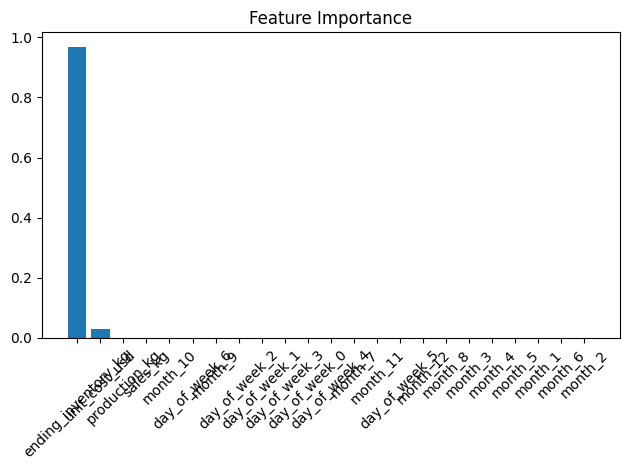

In [16]:
importance = best_model.named_steps['regressor'].feature_importances_
feature_names = numeric_features + list(best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
indices = np.argsort(importance)[::-1]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(len(importance)), importance[indices])
plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

## 10. Deployment Plan

- **Model Serialization:** Save the trained model using `joblib`.
- **API Endpoint:** Wrap the model in a simple Flask/Django API for real-time predictions.
- **Monitoring:** Track prediction performance and data drift.


In [17]:
# Save model
joblib.dump(best_model, 'inventory_value_model.joblib')
print("Model saved to inventory_value_model.joblib")

Model saved to inventory_value_model.joblib


## 11. Conclusion & Next Steps
 
- We built an end-to-end ML pipeline from synthetic data generation to model evaluation.
- The Random Forest model achieved an R2 of {r2:.2%}. 
- Next steps:
1. Integrate with real Odoo data.
2. Automate data ingestion and retraining pipeline.
3. Deploy API and dashboard for stakeholders.
4. Continuously monitor and refine the model.


> **Ready for production!**  
> This solution demonstrates the value of a Data Science Production Engineer in optimizing inventory costs and supporting data-driven decisions.